CITS4403 Project -- Quantifying Stigmergy in Agent Based Models of Ant behavior <br/>
Fraser Paterson (22258324) <br/>
Mila Zhang (22756463)

# Model Definition and Configuration

Code Adjusted from [Active inferants The basis for an active inference framework for ant colony behavior](https://www.researchgate.net/publication/348003553_Active_inferants_The_basis_for_an_active_inference_framework_for_ant_colony_behavior) by Daniel Friedman, Alexander Tschantz, Maxwell Ramstead, Karl Friston, Axel Constant.

## Importing libraries

In [ ]:
!pip install esda

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

from sklearn.cluster import DBSCAN
from esda.moran import Moran
from libpysal.weights import lat2W

## Configurations

In [3]:
ADD_ANT_EVERY = 50  # An integer representing the frequency at which ants are added to the simulation
INIT_X = 20  # Initial coordinate x for the ants when they start in the simulation
INIT_Y = 30  # Initial coordinate y for the ants when they start in the simulation

GRID = [40, 40]  # Define grid size
GRID_SIZE = np.prod(GRID)   # Calculate the total number of grid cells

FOCAL_AREA = [3, 3]  # Dimensions of a focal area within the grid: an ant and its 8 neighborhoods
FOCAL_SIZE = np.prod(FOCAL_AREA)  # Calculate the total number of cells within the focal area
ACTION_MAP = [(-1, -1), (0, -1), (1, -1), (-1, 0), (0, 0), (1, 0), (-1, 1), (0, 1), (1, 1)]  # Define possible directions of one move
OPPOSITE_ACTIONS = list(reversed(range(len(ACTION_MAP))))  # Reversed order of possible directions of one move

FOOD_LOCATION = [30, 5]   # Initial location of the food source
FOOD_SIZE = [10, 10]  # The size of the food resource area

# Define the positions of walls or barriers in the simulation
WALL_LEFT = 0
WALL_RIGHT = 40
WALL_TOP = 0

NUM_PHEROMONE_LEVELS = 10  # The number of discrete levels for pheromone intensity
# DECAY_FACTOR = 1.0  # Define the rate at which pheromone intensity decays over time

NUM_OBSERVATIONS = NUM_PHEROMONE_LEVELS  # The number of possible observations, likely related to pheromone levels
NUM_STATES = FOCAL_SIZE  # The number of possible states within the focal area
NUM_ACTIONS = FOCAL_SIZE   # The number of possible actions within the focal area

## Definitions
We assume that all simulated ants start at the same nest location and each ant will be added to the starting position one by one at stated intervals. Each ant does not know where the food source is located and is only able to detect its immediate surroundings without bias. At each time step, each ant stays at the original spot or move into a neighbour cell. They will find a food source in the environment and move backwards to the original location following the same path they navigate to the food source. And once they move back to the nest, they will again move toward locally increased density of pheromone. The ants will not deposit pheromone before they encounter the food and only one type of pheromones will be generated and left by ants in this simulation whereas there are multiple kinds of pheromones in reality.

### Ant

In [4]:
class Ant(object):
    '''
    An Ant class represents each ant agent and its behavior.
    '''
    def __init__(self, mdp, init_x, init_y):
        '''
        Constructor method that initializes an instance of the `Ant` class.
        '''
        self.mdp = mdp  # Store the Markov Decision Process (MDP) related to the ant's behavior
        self.x_pos = init_x  # Initial x coordinate for the ant position
        self.y_pos = init_y  # Initial y coordinate for the ant position
        self.traj = [(init_x, init_y)]  # A list to store the trajectory of the ant
        self.distance = []  # A list to store the distances between the ant's current position and the initial position
        self.backward_step = 0  # Represnet the number of backward steps taken by the ant
        self.is_returning = False  # Whether the ant is currently returning to the nest
        self.number_of_round_trips = 0  # The number of round trips

    def update_forward(self, x_pos, y_pos):
        '''
        Update the ant's position, trajectory and distance when it moves forward.
        '''
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.traj.append((x_pos, y_pos))
        self.distance.append(dis(x_pos, y_pos, INIT_X, INIT_Y))

    def update_backward(self, x_pos, y_pos):
        '''
        Update the ant's position and distance when it moves backward.
        '''
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.distance.append(dis(x_pos, y_pos, INIT_X, INIT_Y))

### Env

In [5]:
class Env(object):
    '''
    An Env class represents the environment within which the ants move and interact.
    This class contains methods and attributes to manage the environment, including updating ant positions, handling observations, checking for obstacles, and visualizing the environment.
    '''

    def __init__(self, decay_factor):
        '''
        Constructor method that initializes an instance of the `Env` class.
        '''
        self.visit_matrix = np.zeros((GRID[0], GRID[1]))  # A 2D array to track the visitation count of each location
        self.obs_matrix = np.zeros((NUM_OBSERVATIONS, GRID[0], GRID[1]))  # A 3D matrix to represent the observation matrix
        self.obs_matrix[0, :, :] = 0.0  # Initialize the observation matrix with all zeros in the first observation, indicating that all locations are not initially observable
        self.decay_factor = decay_factor

    def get_A(self, ant):
        '''
        Return the observation matrix A for a given ant's position.
        '''
        A = np.zeros((NUM_OBSERVATIONS, NUM_STATES))
        for s in range(NUM_STATES):
            delta = ACTION_MAP[s]
            A[:, s] = self.obs_matrix[:, ant.x_pos + delta[0], ant.y_pos + delta[1]]
        return A

    def get_obs(self, ant):
        '''
        Return the observation index for a given ant's position.
        '''
        obs_vec = self.obs_matrix[:, ant.x_pos, ant.y_pos]
        return np.argmax(obs_vec)

    def check_food(self, x_pos, y_pos):
        '''
        Check if a given position contains food.
        '''
        is_food = False
        if (x_pos > (FOOD_LOCATION[0] - FOOD_SIZE[0])) and (
            x_pos < (FOOD_LOCATION[0] + FOOD_SIZE[0])
        ):
            if (y_pos > (FOOD_LOCATION[1] - FOOD_SIZE[1])) and (
                y_pos < (FOOD_LOCATION[1] + FOOD_SIZE[1])
            ):
                is_food = True
        return is_food

    def check_walls(self, orig_x, orig_y, x_pos, y_pos):
        '''
        Check if an ant encounters walls or obstacles.
        '''
        valid = True
        if orig_y > WALL_TOP:
            if orig_x >= WALL_LEFT and x_pos <= WALL_LEFT:
                valid = False
            if orig_x <= WALL_RIGHT and x_pos >= WALL_RIGHT:
                valid = False
        if orig_y <= WALL_TOP:
            if y_pos > WALL_TOP and ((x_pos < WALL_LEFT) or (x_pos > WALL_RIGHT)):
                valid = False
        return valid

    def step_forward(self, ant, action):
        '''
        Update an ant's position based on the selected action (direction).
        '''
        delta = ACTION_MAP[action]
        x_pos = np.clip(ant.x_pos + delta[0], 1, GRID[0] - 2)
        y_pos = np.clip(ant.y_pos + delta[1], 1, GRID[1] - 2)

        if self.check_food(x_pos, y_pos):
            # If an ant finds food it will start returning to the nest
            ant.is_returning = True
            ant.backward_step = 0

        if self.check_walls(ant.x_pos, ant.y_pos, x_pos, y_pos):
            # Check for wall collisions and update the ant's position accordingly
            ant.update_forward(x_pos, y_pos)

    def step_backward(self, ant):
        '''
        Backward step for an ant returning to the nest.
        '''
        path_len = len(ant.traj)
        next_step = path_len - (ant.backward_step + 1)
        pos = ant.traj[next_step]
        ant.update_backward(pos[0], pos[1])

        # Update visitation count and observation matrix
        self.visit_matrix[pos[0], pos[1]] += 1
        curr_obs = np.argmax(self.obs_matrix[:, pos[0], pos[1]])
        curr_obs = min(curr_obs + 1, NUM_OBSERVATIONS - 1)

        self.obs_matrix[:, pos[0], pos[1]] = 0.0
        self.obs_matrix[curr_obs, pos[0], pos[1]] = 1.0

        ant.backward_step += 1
        if ant.backward_step >= path_len - 1:
            ant.is_returning = False
            traj = ant.traj
            ant.traj = []
            return True, traj
        else:
            return False, None

    def decay(self):
        '''
        Decay the observation matrix which stores pheromone information over time.
        '''
        for x in range(GRID[0]):
            for y in range(GRID[1]):
                curr_obs = np.argmax(self.obs_matrix[:, x, y])
                if (curr_obs > 0) and (np.random.rand() < self.decay_factor):
                    curr_obs = curr_obs - 1
                    self.obs_matrix[:, x, y] = 0.0
                    self.obs_matrix[curr_obs, x, y] = 1.0

    def get_nonzero_pheromone_locations(self):
        '''
        Get non-zero pheromone locations.
        '''
        pheromone_locations = []
        for x in range(GRID[0]):
            for y in range(GRID[1]):
                curr_obs = np.argmax(self.obs_matrix[:, x, y])
                if curr_obs > 0.0:
                    pheromone_locations.append((x, y))
        return np.array(pheromone_locations)

    def get_values(self, ants):
        ant_locations = []
        pheromone_values = []
        for ant in ants:
            ant_locations.append((ant.x_pos, ant.y_pos))
            pheromone_values.append(np.argmax(self.obs_matrix[:, ant.x_pos, ant.y_pos]))
        return np.array(ant_locations), np.array(pheromone_values)

    def run_dbscan_on_pheromone_locs(self, eps, min_samples):
        pheromone_locations = self.get_nonzero_pheromone_locations()
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        labels = dbscan.fit_predict(pheromone_locations)
        return labels

    def run_dbscan_on_ant_locs(self, eps, min_samples, ants):
        ant_locations, _ = self.get_values(ants)
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        labels = dbscan.fit_predict(ant_locations)
        return labels

    def plot(self, ants, savefig=False, name="", ant_only_gif=False):
        '''
        Plot the environment, ant trajectories, and sensory cues.
        '''
        x_pos_forward, y_pos_forward = [], []
        x_pos_backward, y_pos_backward = [], []
        for ant in ants:
            if ant.is_returning:
                x_pos_backward.append(ant.x_pos)
                y_pos_backward.append(ant.y_pos)
            else:
                x_pos_forward.append(ant.x_pos)
                y_pos_forward.append(ant.y_pos)

        img = np.ones((GRID[0], GRID[1]))
        fig, ax = plt.subplots()
        ax.imshow(img.T, cmap="gray")
        plot_matrix = np.zeros((GRID[0], GRID[1]))

        for x in range(GRID[0]):
            for y in range(GRID[1]):
                curr_obs = np.argmax(self.obs_matrix[:, x, y])
                plot_matrix[x, y] = curr_obs

        if ant_only_gif == False:
            ax.imshow(plot_matrix.T, alpha=0.7, vmin=0)

        # Overlay the green rectangle for FOOD_LOCATION
        food_x, food_y = FOOD_LOCATION
        food_width, food_height = FOOD_SIZE
        ax.add_patch(plt.Rectangle((food_x, food_y), food_width, food_height, color="green", alpha=0.5))

        if not savefig:
            ax.scatter(x_pos_forward, y_pos_forward, color="red", s=5)
            ax.scatter(x_pos_backward, y_pos_backward, color="blue", s=5)

        if not savefig:
            fig.canvas.draw()
            img = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
            img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close("all")
            return img
        else:
            plt.savefig(name)
        plt.close("all")

### MDP (Markov Decision Process)

In [6]:
class MDP(object):
    '''
    The MDP class represents a Markov Decision Process (MDP) used in the ant simulation.
    It initializes the MDP with transition matrices A, B, and C, and provides methods for state inference, action inference, and other MDP-related operations.
    '''
    def __init__(self, A, B, C):
        '''
        Constructor method that initializes an instance of the `MDP` class.

        Args:
            A (numpy.ndarray): Transition matrix A.
            B (numpy.ndarray): Transition matrix B.
            C (numpy.ndarray): Transition matrix C.
        '''
        self.A = A
        self.B = B
        self.C = C
        self.p0 = np.exp(-16)

        self.num_states = self.A.shape[1]
        self.num_obs = self.A.shape[0]
        self.num_actions = self.B.shape[0]

        self.A = self.A + self.p0
        self.A = self.normdist(self.A)
        self.lnA = np.log(self.A)

        self.B = self.B + self.p0
        for a in range(self.num_actions):
            self.B[a] = self.normdist(self.B[a])

        self.C = self.C + self.p0
        self.C = self.normdist(self.C)

        self.sQ = np.zeros([self.num_states, 1])
        self.uQ = np.zeros([self.num_actions, 1])
        self.prev_action = None
        self.t = 0

    def set_A(self, A):
        '''
        Set the transition matrix A.

        Args:
            A (numpy.ndarray): New transition matrix A.
        '''
        self.A = A + self.p0
        self.A = self.normdist(self.A)
        self.lnA = np.log(self.A)

    def reset(self, obs):
        '''
        Reset the MDP with a new observation.

        Args:
            obs (int): The new observation.
        '''
        self.t = 0
        self.curr_obs = obs
        likelihood = self.lnA[obs, :]
        likelihood = likelihood[:, np.newaxis]
        self.sQ = self.softmax(likelihood)
        self.prev_action = self.random_action()

    def step(self, obs):
        '''
        Perform a step in the MDP.

        Args:
            obs (int): The current observation.

        Returns:
            int: The selected action.
        '''
        # State inference
        likelihood = self.lnA[obs, :]
        likelihood = likelihood[:, np.newaxis]
        prior = np.dot(self.B[self.prev_action], self.sQ)
        prior = np.log(prior)
        self.sQ = self.softmax(prior)

        # Action inference
        SCALE = 10
        neg_efe = np.zeros([self.num_actions, 1])
        for a in range(self.num_actions):
            fs = np.dot(self.B[a], self.sQ)
            fo = np.dot(self.A, fs)
            fo = self.normdist(fo + self.p0)
            utility = np.sum(fo * np.log(fo / self.C), axis=0)
            utility = utility[0]
            neg_efe[a] -= utility / SCALE

        # Priors
        neg_efe[4] -= 20.0
        neg_efe[OPPOSITE_ACTIONS[self.prev_action]] -= 20.0  # type: ignore

        # Action selection
        self.uQ = self.softmax(neg_efe)
        action = np.argmax(np.random.multinomial(1, self.uQ.squeeze()))
        self.prev_action = action
        return action

    def random_action(self):
        '''
        Generate a random action.

        Returns:
            int: A random action.
        '''
        return int(np.random.choice(range(self.num_actions)))

    @staticmethod
    def softmax(x):
        '''
        Compute the softmax of an input vector x.

        Args:
            x (numpy.ndarray): Input vector.

        Returns:
            numpy.ndarray: Softmax of the input vector.
        '''
        x = x - x.max()
        x = np.exp(x)
        x = x / np.sum(x)
        return x

    @staticmethod
    def normdist(x):
        '''
        Normalize the input distribution x.

        Args:
            x (numpy.ndarray): Input distribution.

        Returns:
            numpy.ndarray: Normalized distribution.
        '''
        return np.dot(x, np.diag(1 / np.sum(x, 0)))

### Create_ant

In [7]:
def create_ant(init_x, init_y, C):
    '''
    Create an ant with the specified initial position and custom prior C.

    Args:
        init_x (int): Initial X position.
        init_y (int): Initial Y position.
        C (numpy.ndarray): Custom prior matrix C.

    Returns:
        Ant: The created ant.
    '''
    A = np.zeros((NUM_OBSERVATIONS, NUM_STATES))
    B = np.zeros((NUM_ACTIONS, NUM_STATES, NUM_STATES))
    for a in range(NUM_ACTIONS):
        B[a, a, :] = 1.0
    mdp = MDP(A, B, C)
    ant = Ant(mdp, init_x, init_y)
    return ant


def dis(x1, y1, x2, y2):
    '''
    Calculate the Euclidean distance between two points.

    Args:
        x1 (float): X coordinate of the first point.
        y1 (float): Y coordinate of the first point.
        x2 (float): X coordinate of the second point.
        y2 (float): Y coordinate of the second point.

    Returns:
        float: Euclidean distance between the two points.
    '''
    return np.sqrt(((x1 - x2) ** 2) + ((y1 - y2) ** 2))


def plot_path(path, save_name):
    '''
    Plot a path and save it as an image.

    Args:
        path (numpy.ndarray): Path to plot.
        save_name (str): Name of the image file to save.
    '''
    path = np.array(path)
    _, ax = plt.subplots(1, 1)
    ax.set_xlim(GRID[0])
    ax.set_ylim(GRID[1])
    ax.plot(path[:, 0], path[:, 1], "-o", color="red", alpha=0.4)
    plt.savefig(save_name)
    plt.close("all")


def save_gif(imgs, path, fps=32):
    '''
    Save a series of images as a GIF.

    Args:
        imgs (list): List of images to save as frames in the GIF.
        path (str): Path to save the GIF file.
        fps (int): Frames per second for the GIF.
    '''
    imageio.mimsave(path, imgs, fps=fps)

### Main

In [8]:
def main(num_steps, decay_factor, init_ants, max_ants, C, ctr, num_runs, save=True, switch=False, name="", ant_only_gif=False):
    '''
    The main simulation function that runs the ant simulation.

    Args:
        num_steps (int): Number of simulation steps.
        decay_factor (float): Decay rate of the pheromone.
        init_ants (int): Number of initial ants.
        max_ants (int): Maximum number of ants.
        C (numpy.ndarray): Custom prior matrix C.
        ctr:
        num_runs:
        save (bool): Flag to save images and GIF.
        switch (bool): Flag to switch food location.
        name (str): Name for saving simulation files.
        ant_only_gif (bool): Flag to generate an ant-only GIF.

    Returns:
        Tuple: A tuple containing the number of completed trips, list of paths, and total distance.
    '''
    # Initialize ants and set up the environment
    env = Env(decay_factor)
    ants = []
    paths = []
    for _ in range(init_ants):
        ant = create_ant(INIT_X, INIT_Y, C)
        obs = env.get_obs(ant)
        A = env.get_A(ant)
        ant.mdp.set_A(A)
        ant.mdp.reset(obs)
        ants.append(ant)

    imgs = []
    completed_trips = 0

    Morans_i_values = []

    distance = 0
    distances = []

    cluster_densities = []
    num_clusters = []

    ant_locations = []
    num_round_trips_per_time = []

    num_rt_at_time_t = 0

    for t in range(num_steps):
        t_dis = 0

        for ant in ants:
            for ant_2 in ants:
                t_dis += dis(ant.x_pos, ant.y_pos, ant_2.x_pos, ant_2.y_pos)

        current_avg_dist = t_dis / len(ants)
        distance += current_avg_dist
        distances.append(current_avg_dist)

        ant_positions, pheromone_values = env.get_values(ants)

        # Combine ant locations and pheromone values
        Z = np.column_stack((ant_positions, pheromone_values))

        # Create weight matrix
        w = lat2W(Z.shape[0], Z.shape[1])

        # Create PySAL Moran obj
        m_i = Moran(Z, w)

        # add to the Moran's I list
        Morans_i_values.append(m_i.I)

        if len(paths) == 0:
            cluster_densities.append(0)
            num_clusters.append(0)
        else:

            # ant_trajectory_locations = [point for trajectory in paths for point in trajectory]


            # Create and fit a DBSCAN model
            eps = 5
            # min_samples = len(ants) // 5
            min_samples = 3
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(ant_positions)

            # the number of DBSCAN Clusters
            n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

            # Calculate cluster sizes
            cluster_sizes = [len(ant_positions[dbscan_labels == label]) for label in set(dbscan_labels)]

            # Calculate the average density
            if cluster_sizes:
                average_density = len(ant_positions) / len(cluster_sizes)
            else:
                average_density = 0

            # print("Average Density of Clusters:", average_density)

            cluster_densities.append(average_density)
            num_clusters.append(n_clusters)


        if t % 100 == 0:
            print(f"Step {t + 1}/{num_steps} of Simulation {ctr + 1}/{num_runs}")

        if t % ADD_ANT_EVERY == 0 and len(ants) < max_ants:
            ant = create_ant(INIT_X, INIT_Y, C)
            obs = env.get_obs(ant)
            A = env.get_A(ant)
            ant.mdp.set_A(A)
            ant.mdp.reset(obs)
            ants.append(ant)

        for ant in ants:
            if not ant.is_returning:
                obs = env.get_obs(ant)
                A = env.get_A(ant)
                ant.mdp.set_A(A)
                action = ant.mdp.step(obs)
                env.step_forward(ant, action)
            else:
                is_complete, traj = env.step_backward(ant)
                completed_trips += int(is_complete)

                if is_complete:
                    paths.append(traj)

                    # Increment the number of round trips by 1
                    ant.number_of_round_trips += 1
                    num_rt_at_time_t += 1

        num_round_trips_per_time.append(num_rt_at_time_t)

        # if save:
        #     if t in np.arange(0, num_steps, num_steps // 30):
        #     # if t in np.arange(0, num_steps):
        #         env.plot(ants, savefig=True, name=f"my_imgs_full_sim/{name}_{t}.png")
        #     else:
        #         img = env.plot(ants, ant_only_gif=ant_only_gif)
        #         imgs.append(img)

        # round_trips_over_time.append(completed_trips / max_ants)
        ant_locations.append([[ant.x_pos, ant.y_pos] for ant in ants])

    # if save:
    #     save_gif(imgs, f"my_imgs_full_sim/{name}.gif")


    ant_locations = np.array(ant_locations)

    # np.save(f"my_imgs_full_sim/{name}_locations", ant_locations)


    return completed_trips, np.array(paths, dtype=object), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values

# Simulation and Visualisation

## Simulations with different ant populations

Step 1/1000 of Simulation 1/5
Step 101/1000 of Simulation 1/5
Step 201/1000 of Simulation 1/5
Step 301/1000 of Simulation 1/5
Step 401/1000 of Simulation 1/5
Step 501/1000 of Simulation 1/5
Step 601/1000 of Simulation 1/5
Step 701/1000 of Simulation 1/5
Step 801/1000 of Simulation 1/5
Step 901/1000 of Simulation 1/5
Step 1/1000 of Simulation 2/5
Step 101/1000 of Simulation 2/5
Step 201/1000 of Simulation 2/5
Step 301/1000 of Simulation 2/5
Step 401/1000 of Simulation 2/5
Step 501/1000 of Simulation 2/5
Step 601/1000 of Simulation 2/5
Step 701/1000 of Simulation 2/5
Step 801/1000 of Simulation 2/5
Step 901/1000 of Simulation 2/5
Step 1/1000 of Simulation 3/5
Step 101/1000 of Simulation 3/5
Step 201/1000 of Simulation 3/5
Step 301/1000 of Simulation 3/5
Step 401/1000 of Simulation 3/5
Step 501/1000 of Simulation 3/5
Step 601/1000 of Simulation 3/5
Step 701/1000 of Simulation 3/5
Step 801/1000 of Simulation 3/5
Step 901/1000 of Simulation 3/5
Step 1/1000 of Simulation 4/5
Step 101/1000 of

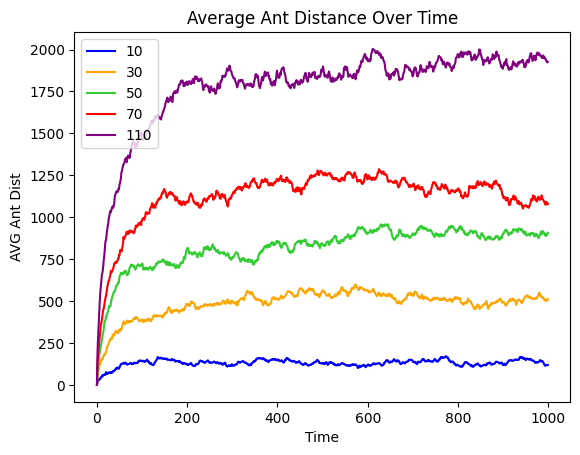

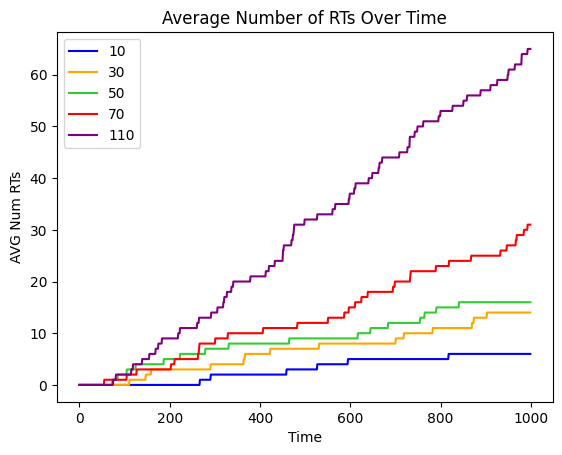

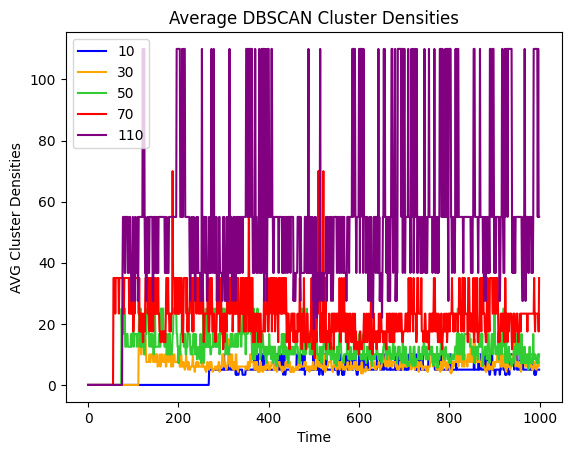

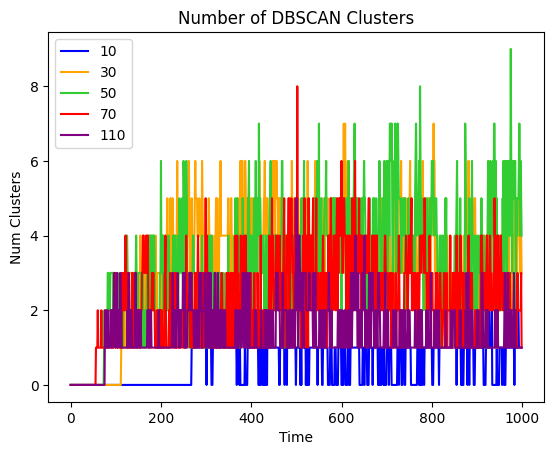

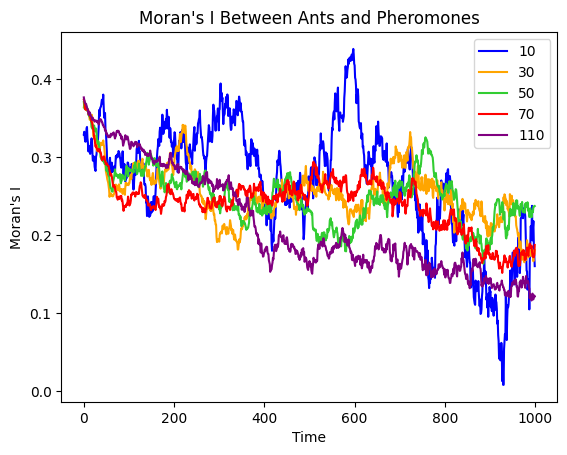

In [9]:
NAME = "main"
NUM_STEPS = 1000  # Number of time steps in simulation
ANT_POPS = [10, 30, 50, 70, 110]  # Different sets of ant population
ANT_POPS_COLOURS = ["blue", "orange", "limegreen", "red", "purple"]  # Colour palette for plotting
ANT_POP_DISTS = []  # List for storing distances
AVG_NUM_RT_PER_POP_SIZE_PER_TIME = []  # List for storing average number of round trips at each time step
MORAN_IS = []  # List for storing Morans_i_values at each time step
CLUSTER_DENSITIES = []  # List for storing cluster_densities at each time step
NUMBER_CLUSTERS = []  # List for storing num_clusters at each time step
DECAY_FACTORS = [1.0]  # Pheromone decay rate

NUM_SIMS = len(ANT_POPS)  # Number of simulations

# Standard prior
PRIOR_TICK = 1
C = np.zeros((NUM_OBSERVATIONS, 1))
prior = 0
for o in range(NUM_OBSERVATIONS):
    C[o] = prior
    prior += PRIOR_TICK

if __name__ == "__main__":

    # Running simulations
    for i in range(NUM_SIMS):

        num_round_trips, paths, coeff, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values = main(
            decay_factor=DECAY_FACTORS[0],
            num_steps=NUM_STEPS,
            init_ants=ANT_POPS[i],
            max_ants=ANT_POPS[i],
            C=C,
            save=True,
            switch=True,
            name=NAME,
            ant_only_gif=False,
            num_runs = NUM_SIMS,
            ctr = i
        )

        ANT_POP_DISTS.append(distances)
        CLUSTER_DENSITIES.append(cluster_densities)
        NUMBER_CLUSTERS.append(num_clusters)
        AVG_NUM_RT_PER_POP_SIZE_PER_TIME.append(num_round_trips_per_time)
        MORAN_IS.append(Morans_i_values)


    # Visualisation
    plt.title("Average Ant Distance Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Ant Dist")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            ANT_POP_DISTS[i],
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average Number of RTs Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Num RTs")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            AVG_NUM_RT_PER_POP_SIZE_PER_TIME[i],
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average DBSCAN Cluster Densities")
    plt.xlabel("Time")
    plt.ylabel("AVG Cluster Densities")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            CLUSTER_DENSITIES[i],
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Number of DBSCAN Clusters")
    plt.xlabel("Time")
    plt.ylabel("Num Clusters")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            NUMBER_CLUSTERS[i],
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Moran's I Between Ants and Pheromones")
    plt.xlabel("Time")
    plt.ylabel("Moran's I")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            MORAN_IS[i],
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

## Simulations with different pheromone decay factors

Step 1/1000 of Simulation 1/5
Step 101/1000 of Simulation 1/5
Step 201/1000 of Simulation 1/5
Step 301/1000 of Simulation 1/5
Step 401/1000 of Simulation 1/5
Step 501/1000 of Simulation 1/5
Step 601/1000 of Simulation 1/5
Step 701/1000 of Simulation 1/5
Step 801/1000 of Simulation 1/5
Step 901/1000 of Simulation 1/5
Step 1/1000 of Simulation 2/5
Step 101/1000 of Simulation 2/5
Step 201/1000 of Simulation 2/5
Step 301/1000 of Simulation 2/5
Step 401/1000 of Simulation 2/5
Step 501/1000 of Simulation 2/5
Step 601/1000 of Simulation 2/5
Step 701/1000 of Simulation 2/5
Step 801/1000 of Simulation 2/5
Step 901/1000 of Simulation 2/5
Step 1/1000 of Simulation 3/5
Step 101/1000 of Simulation 3/5
Step 201/1000 of Simulation 3/5
Step 301/1000 of Simulation 3/5
Step 401/1000 of Simulation 3/5
Step 501/1000 of Simulation 3/5
Step 601/1000 of Simulation 3/5
Step 701/1000 of Simulation 3/5
Step 801/1000 of Simulation 3/5
Step 901/1000 of Simulation 3/5
Step 1/1000 of Simulation 4/5
Step 101/1000 of

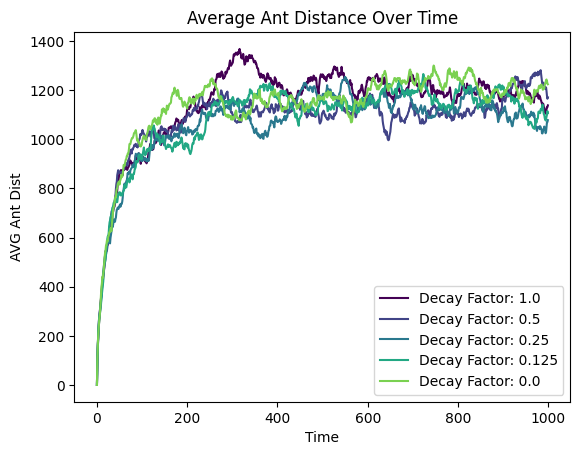

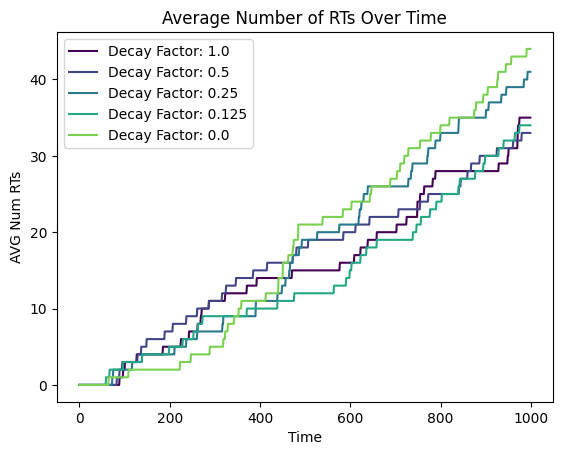

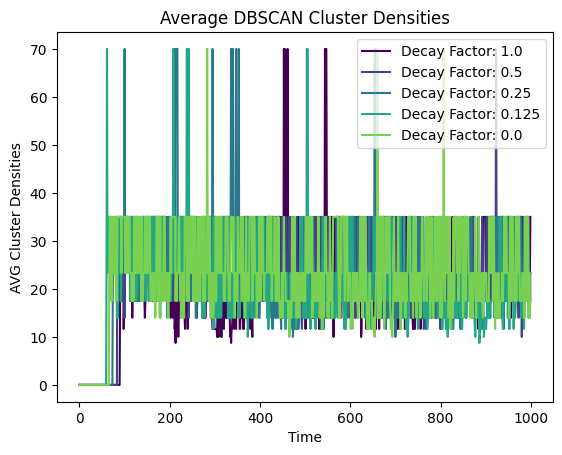

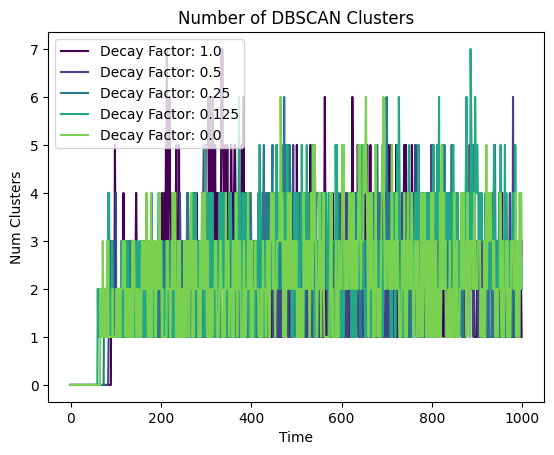

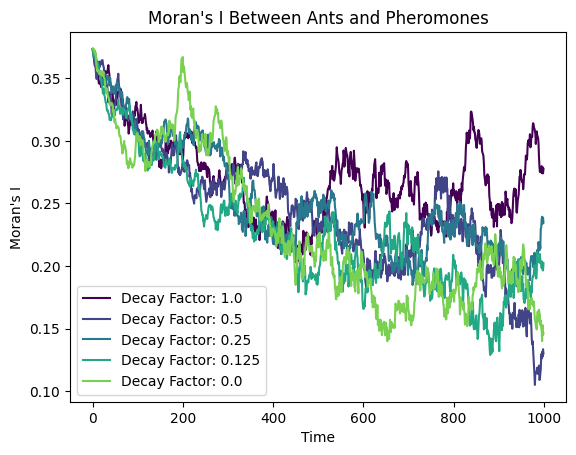

In [10]:
NAME = "main"
NUM_STEPS = 1000  # Number of time steps in simulation
ANT_POPS = 70  # Ant population
CMAP = plt.get_cmap("viridis")  # Retrieve color map "viridis"
ANT_POP_DISTS = []  # List for storing ant distances
AVG_NUM_RT_PER_POP_SIZE_PER_TIME = []  # List for storing average number of round trips at each time step
MORAN_IS = []  # List for storing Moran's I values at each time step
CLUSTER_DENSITIES = []  # List for storing cluster densities at each time step
NUMBER_CLUSTERS = []  # List for storing number of clusters at each time step
DECAY_FACTORS = [1.0, 0.5, 0.25, 0.125, 0.0]  # Defferent sets of pheromone decay rate
COLOURS = [CMAP(i / len(DECAY_FACTORS)) for i in range(len(DECAY_FACTORS))]  # Define colours for plotting

NUM_SIMS = len(DECAY_FACTORS)  # Number of simulations

# Standard prior
PRIOR_TICK = 1
C = np.zeros((NUM_OBSERVATIONS, 1))
prior = 0
for o in range(NUM_OBSERVATIONS):
    C[o] = prior
    prior += PRIOR_TICK

if __name__ == "__main__":

    # Running simulations
    for i in range(NUM_SIMS):

        num_round_trips, paths, coeff, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values = main(
            decay_factor=DECAY_FACTORS[i],
            num_steps=NUM_STEPS,
            init_ants=ANT_POPS,
            max_ants=ANT_POPS,
            C=C,
            save=True,
            switch=True,
            name=NAME,
            ant_only_gif=False,
            num_runs = NUM_SIMS,
            ctr = i
        )

        ANT_POP_DISTS.append(distances)
        CLUSTER_DENSITIES.append(cluster_densities)
        NUMBER_CLUSTERS.append(num_clusters)
        AVG_NUM_RT_PER_POP_SIZE_PER_TIME.append(num_round_trips_per_time)
        MORAN_IS.append(Morans_i_values)

    # Visualisation
    plt.title("Average Ant Distance Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Ant Dist")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            ANT_POP_DISTS[i],
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average Number of RTs Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Num RTs")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            AVG_NUM_RT_PER_POP_SIZE_PER_TIME[i],
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average DBSCAN Cluster Densities")
    plt.xlabel("Time")
    plt.ylabel("AVG Cluster Densities")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            CLUSTER_DENSITIES[i],
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Number of DBSCAN Clusters")
    plt.xlabel("Time")
    plt.ylabel("Num Clusters")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            NUMBER_CLUSTERS[i],
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Moran's I Between Ants and Pheromones")
    plt.xlabel("Time")
    plt.ylabel("Moran's I")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)],
            MORAN_IS[i],
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()